# Sequence Models

**Summary**
* Generate a toy dataset using sine curve + gaussian noise.
* Train a autoregressive MLP
* Demonstrates that model does well on 1-step ahead prediction but fails to predict k-step ahead prediction when k is large

**Changes** 
- 30-03-2021 - Created


* In context of Netflix ratings, what is anchoring, hedonic adpatation, seasonality?
* Are movie ratings for a person stationary?
* Give examples of structure in sequential data
    - Earthquakes
    - Stock Prices
    - Usage patterns of social media vs stock broker app    

Time Series prediction poses the following estimation problem

$$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1)$$

* What is an autoregressive model?
* What is a latent autoregressive model?

TS Modeling Assumption: Even though the specific values of $x_t$ change, the dynamics of the sequence itself do not change over time. 
* What is Stationarity?
* What is a Markov Model? What's a first order Markov Model?
    $$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ where } P(x_1 \mid x_0) = P(x_1)$$

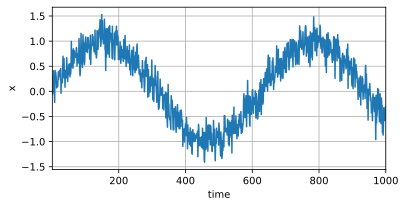

In [69]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l


T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

$\tau$ is the embedding dimension $\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$ is taken as feature vector. 

$T$ is the length of the sequence.

In [70]:
tau = 4
batch_size = 16
n_train = 600

We slide windows of size `K = (tau + 1)` where the first tau elements are inputs and the last element is output. There are `T - K + 1 = T - tau` such sliding windows.

In [71]:
features = torch.zeros((T - tau, tau))

In [72]:
for i in range(T - tau):
    features[i] = x[i:(i+tau)]

labels = x[tau:].reshape(-1,1)

In [73]:
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), 
                           batch_size, is_train=True)

In [74]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

In [75]:
def get_net():
    net = nn.Sequential(nn.Linear(4,10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

In [76]:
loss = nn.MSELoss()

In [77]:
def train(net, train_iter, loss, n_epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(n_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(y, net(X))
            l.backward()
            trainer.step()
            
        print(f"epoch {epoch + 1}, "
             f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

In [78]:
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.052904
epoch 2, loss: 0.047880
epoch 3, loss: 0.046629
epoch 4, loss: 0.049694
epoch 5, loss: 0.045691


In [79]:
onestep_preds = net(features)

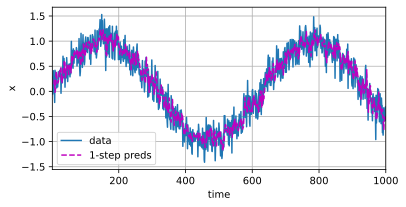

In [80]:
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1,1000], figsize=(6,3))

* What is one step ahead prediction? What is k-step-ahead prediction

In [81]:
# multistep_preds = torch.zeros(T)
# multistep_preds[:n_train + tau] = x[:n_train + tau]
# for i in range(n_train + tau, T):
#     multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

In [82]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i-tau:i])

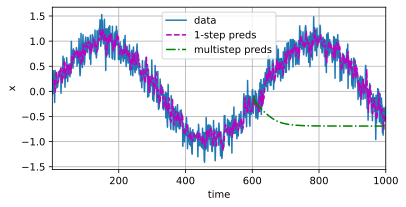

In [83]:
d2l.plot([time, time[tau:], time[n_train + tau:]], [
    x.detach().numpy(),
    onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x',
         legend=['data', '1-step preds',
                 'multistep preds'], xlim=[1, 1000], figsize=(6, 3))

R: Why did the algorithm work so poorly on multi-step ahead prediction?

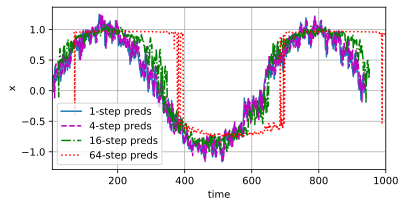

In [86]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time',
         'x', legend=[f'{i}-step preds'
                      for i in steps], xlim=[5, 1000], figsize=(6, 3))

In [88]:
features.shape

torch.Size([933, 68])